<a href="https://colab.research.google.com/github/javahedi/QuantumStateTomography-ML/blob/main/main_last_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [218]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, Concatenate

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
import glob

In [219]:
# Check available devices
devices = tf.config.experimental.list_physical_devices('GPU')  # Check for GPU
if devices:
    print("Using GPU")
    tf.config.experimental.set_visible_devices(devices[0], 'GPU')  # Use the first GPU
else:
    print("Using CPU")

Using CPU


In [220]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [221]:
path         = "/content/drive/MyDrive/SL_data/"
cvs_names    = glob.glob(f'{path}*.csv')
bank_names   = glob.glob(f'{path}*bank.npy')
weight_names = glob.glob(f'{path}*weights.npy')

angles_list  = []
banks_list   = []
weights_list = []
for id, name in enumerate(cvs_names):
    data    = np.loadtxt( os.path.join(path,cvs_names[id]),delimiter=',',skiprows=1)
    bank    = np.load(bank_names[id],mmap_mode="r")
    weights = np.load(weight_names[id],mmap_mode="r")

    angles_list.append(data)
    banks_list.append(bank[1:])
    weights_list.append(weights[1:])


angles_data   = np.stack(angles_list)
banks_data    = np.stack(banks_list)
weights_data  = np.stack(weights_list)

angles_data[:,:,0] = np.sin(angles_data[:,:,0])
angles_data[:,:,1] = np.sin(angles_data[:,:,1]/4.0)

angles_data[:,:,-2] = np.sin(angles_data[:,:,-2])
angles_data[:,:,-1] = np.sin(angles_data[:,:,-1]/4.0)


print(angles_data.shape)
print(banks_data.shape)
print(weights_data.shape)

(1000, 99, 5)
(1000, 99, 100, 2, 2)
(1000, 99, 100)


In [222]:
X,y=angles_data[:,:,:3],angles_data[:,:,3:]

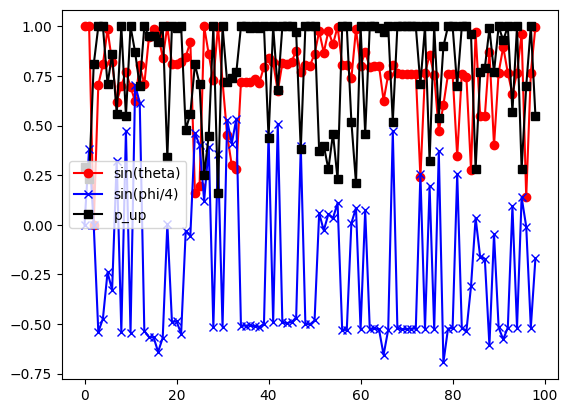

In [223]:
plt.plot(X[1,:,0],'o-r',label='sin(theta)')
plt.plot(X[1,:,1],'x-b',label='sin(phi/4)')
plt.plot(X[1,:,2],'s-k',label='p_up')
plt.legend()
plt.show()

In [224]:
# Set the percentage of data to use for validation
validation_split = 0.2

# Determine the number of samples to use for validation
num_validation_samples = int(angles_data.shape[0] * validation_split)

# Split the data into training and validation sets
train_data_angles  = angles_data[:-num_validation_samples]
train_data_banks   = banks_data[:-num_validation_samples]
train_data_weights = weights_data[:-num_validation_samples]

validation_data_angles  = angles_data[-num_validation_samples:]
validation_data_banks   = banks_data[-num_validation_samples:]
validation_data_weights = weights_data[-num_validation_samples:]

In [225]:
# Set batch size
batch_size = 32

# TensorFlow datasets API
#train_dataset      = tf.data.Dataset.from_tensor_slices(train_data_angles).repeat().batch(batch_size, drop_remainder=True)

train_dataset      = tf.data.Dataset.from_tensor_slices(train_data_angles).batch(batch_size, drop_remainder=True)
validation_dataset = tf.data.Dataset.from_tensor_slices(validation_data_angles).batch(batch_size, drop_remainder=True)


In [226]:
print(train_dataset.element_spec)


TensorSpec(shape=(32, 99, 5), dtype=tf.float64, name=None)


In [238]:
class CustomLoss(tf.keras.losses.Loss):
    def __init__(self, bank_particles, weights, lambda_weight=1.0, **kwargs):
        super(CustomLoss, self).__init__(**kwargs)
        self.bank_particles = bank_particles
        self.weights        = weights
        self.lambda_weight  = lambda_weight

    def information_gain(self, angles, bank_particles, weights):
        best_guess = tf.einsum('ijkl,ij->ikl', bank_particles, weights)
        return self.adaptive_cost_func(angles, bank_particles, weights, best_guess)

    def adaptive_cost_func(self, angles, rho_bank, weights, best_guess):
        # Create projector from angles
        povm = self.angles_to_single_qubit_POVM(angles)
        # Compute the entropy of prior and posterior distributions.
        K = self.Shannon_entropy(tf.einsum('nijk,nkj->ni', povm, best_guess))
        J = self.Shannon_entropy(tf.einsum('nijk,nlkj->nil', povm, rho_bank))
        # Return the negative values such that it becomes a minimization problem.
        return tf.math.real(K - tf.einsum("ij,ij->i", J, weights))


    def Shannon_entropy(self, prob):
        epsilon = 1e-10  # Small epsilon value to avoid division by zero
        prob = tf.maximum(prob, epsilon)  # Replace zeros with epsilon
        return tf.math.real(tf.reduce_sum(-(prob * tf.math.log2(prob)), axis=1))

    def angles_to_single_qubit_POVM(self, angles):
        """
        Vectorized function for converting measurement angles to the spin POVM as a 2x2x2 complex array.
        For a single qubit only.
        """
        up_state_vector = tf.convert_to_tensor(
            [tf.math.cos(angles[:, 0] / 2), tf.exp(1j * angles[:, 1]) * tf.math.sin(angles[:, 0] / 2)],
            dtype=tf.complex128,
        )
        up_POVM = tf.einsum("in,jn->nij", up_state_vector, tf.math.conj(up_state_vector))
        return tf.einsum('injk->nijk', tf.convert_to_tensor([up_POVM[:], tf.eye(2) - up_POVM[:]], dtype=tf.complex128))

    #----
    '''
    def call(self, y_true, y_pred):
        mse_target = tf.keras.losses.mean_squared_error(y_true, y_pred)


        # Create an empty tensor with the same size as mse_target
        true_info_gains = tf.TensorArray(dtype=tf.float64, size=tf.shape(y_true)[1])
        pred_info_gains = tf.TensorArray(dtype=tf.float64, size=tf.shape(y_true)[1])

        for i in tf.range(tf.shape(y_true)[1]):
            true_info_gains = true_info_gains.write(i, self.information_gain(y_true[:, i, :], self.bank_particles[:, i, ...], self.weights[:, i]))
            pred_info_gains = pred_info_gains.write(i, self.information_gain(y_pred[:, i, :], self.bank_particles[:, i, ...], self.weights[:, i]))

        #true_info_gains = tf.convert_to_tensor(true_info_gains, dtype=tf.float64)
        #pred_info_gains = tf.convert_to_tensor(pred_info_gains, dtype=tf.float64)

        true_info_gains = true_info_gains.stack()
        pred_info_gains = pred_info_gains.stack()

        loss_infoGain = 1.0 - (pred_info_gains / true_info_gains)
        total_loss = mse_target + self.lambda_weight * tf.transpose(loss_infoGain, perm=[1, 0])

        return tf.reduce_mean(total_loss)
      '''
    def call(self, y_true, y_pred):
          mse_target = tf.keras.losses.mean_squared_error(y_true, y_pred)

          def compute_info_gain(i):
              return self.information_gain(y_true[:, i, :], self.bank_particles[:, i, ...], self.weights[:, i])

          true_info_gains = tf.map_fn(compute_info_gain, tf.range(tf.shape(y_true)[1]), dtype=tf.float64)
          pred_info_gains = tf.map_fn(compute_info_gain, tf.range(tf.shape(y_pred)[1]), dtype=tf.float64)

          loss_infoGain = 1.0 - (pred_info_gains / true_info_gains)
          total_loss = mse_target + self.lambda_weight * tf.transpose(loss_infoGain, perm=[1, 0])

          return tf.reduce_mean(total_loss)



In [239]:
'''
class CustomLoss(tf.keras.losses.Loss):
    def __init__(self, bank_particles, weights, lambda_weight=1.0, **kwargs):
        super(CustomLoss, self).__init__(**kwargs)
        self.bank_particles = bank_particles
        self.weights        = weights
        self.lambda_weight  = lambda_weight


    def information_gain(self, angles, bank_particles, weights):
        best_guess = np.einsum('ijkl,ij->ikl', bank_particles, weights)
        return self.adaptive_cost_func(angles, bank_particles, weights, best_guess)


    def adaptive_cost_func(self, angles,rhoBank,weights,bestGuess):

        # Crates projector from angles
        povm=self.angles_to_single_qubit_POVM(angles)
        # Computes the entropy of prior and posterior distributions. See 10.1103/PhysRevA.85.052120 for more details.
        K=self.Shannon_entropy(np.einsum('nijk,nkj->ni',povm,bestGuess))
        J=self.Shannon_entropy(np.einsum('nijk,nlkj->nil',povm,rhoBank))
        # Returns the negative values such that it becomes a minimization problem rather than maximization problem.
        return np.real(K-np.einsum("ij,ij->i",J,weights))

    def Shannon_entropy(self, prob):
        epsilon = 1e-10  # Small epsilon value to avoid division by zero
        prob = np.maximum(prob, epsilon)  # Replace zeros with epsilon
        return np.real(np.sum(-(prob * np.log2(prob)), axis=1))

    def angles_to_single_qubit_POVM(self, angles):
        """
        Function is now vectorized in 0th index.
        Takes in measurement angles as dictionaries and returns the spin POVM as 2x2x2 complex array .
        For single qubit only.
        """
        up_state_vector=np.array([np.cos(angles[:,0]/2),np.exp(1j*angles[:,1])*np.sin(angles[:,0]/2)],dtype=complex)
        up_POVM=np.einsum("in,jn->nij",up_state_vector,up_state_vector.conj())
        return np.einsum('injk->nijk',np.array([up_POVM[:],np.eye(2)-up_POVM[:]],dtype=complex))


    def call(self, y_true, y_pred):
        mse_target = tf.keras.losses.mean_squared_error(y_true, y_pred)

        true_info_gains = []
        pred_info_gains = []

        for i in  tf.range(tf.shape(y_true)[1]):
            true_info_gains.append(self.information_gain(y_true[:, i, :], self.bank_particles[:, i, ...], self.weights[:, i]))
            pred_info_gains.append(self.information_gain(y_pred[:, i, :], self.bank_particles[:, i, ...], self.weights[:, i]))

        true_info_gains = tf.convert_to_tensor(true_info_gains, dtype=tf.float64)
        pred_info_gains = tf.convert_to_tensor(pred_info_gains, dtype=tf.float64)

        loss_infoGain = 1.0 - (pred_info_gains / true_info_gains)
        total_loss = mse_target + self.lambda_weight * tf.transpose(loss_infoGain, perm=[1, 0])

        return tf.reduce_mean(total_loss)
'''

'\nclass CustomLoss(tf.keras.losses.Loss):\n    def __init__(self, bank_particles, weights, lambda_weight=1.0, **kwargs):\n        super(CustomLoss, self).__init__(**kwargs)\n        self.bank_particles = bank_particles\n        self.weights        = weights\n        self.lambda_weight  = lambda_weight\n\n\n    def information_gain(self, angles, bank_particles, weights):\n        best_guess = np.einsum(\'ijkl,ij->ikl\', bank_particles, weights)\n        return self.adaptive_cost_func(angles, bank_particles, weights, best_guess)\n\n\n    def adaptive_cost_func(self, angles,rhoBank,weights,bestGuess):\n\n        # Crates projector from angles\n        povm=self.angles_to_single_qubit_POVM(angles)\n        # Computes the entropy of prior and posterior distributions. See 10.1103/PhysRevA.85.052120 for more details.\n        K=self.Shannon_entropy(np.einsum(\'nijk,nkj->ni\',povm,bestGuess))\n        J=self.Shannon_entropy(np.einsum(\'nijk,nlkj->nil\',povm,rhoBank))\n        # Returns the ne

In [240]:

# Instantiate the custom loss with the required parameters
custom_loss = CustomLoss(bank_particles=train_data_banks, weights=train_data_weights, lambda_weight=1.0)


In [241]:

# Custom Self-Attention Layer
class SelfAttention(tf.keras.layers.Layer):
    '''
      arXiv:1706.03762v7   ---> Scaled Dot-Product Attention
      Input Shape: (batch_size, sequence_length, feature_dim)

      batch_size     : The number of samples in each batch.
      sequence_length: The length of the sequence in each sample.
      feature_dim    : The number of features in each element of the sequence.

      Output Shape: (batch_size, sequence_length, feature_dim)

          The output preserves the same structure as the input.
          For each element in the sequence, the self-attention mechanism computes a
          weighted sum of all elements in the sequence based on their relationships,
          and the output at each position is a combination of these weighted sums.
    '''

    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w_q = self.add_weight(name="w_q", shape=(input_shape[-1], input_shape[-1]), initializer="uniform", trainable=True)
        self.w_k = self.add_weight(name="w_k", shape=(input_shape[-1], input_shape[-1]), initializer="uniform", trainable=True)
        super(SelfAttention, self).build(input_shape)

    def call(self, x):
        q = tf.matmul(x, self.w_q)
        k = tf.matmul(x, self.w_k)
        v = x
        attention_scores = tf.matmul(q, k, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)
        output = tf.matmul(attention_scores, v)
        return output

In [242]:
# Generate sample data
num_samples = angles_data.shape[0]
data_size   = angles_data.shape[1]
input_size  = 3
output_size = 2

# ReLU function should only be used in the hidden layers.
model = Sequential()
#model.add(Dense(32, input_shape=(data_size, input_size), activation='relu'))
model.add(Dense(32, input_shape=(None, input_size), activation='relu'))
model.add(Dense(64, activation='relu'))             # Additional hidden layer
model.add(SelfAttention())                          # Scaled Dot-Product Attention with self-attention
model.add(Dense(output_size, activation='linear'))  # Linear activation for regression


# Compile the model using the custom loss
model.compile(optimizer='adam', loss=custom_loss)
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, None, 32)          128       
                                                                 
 dense_46 (Dense)            (None, None, 64)          2112      
                                                                 
 self_attention_15 (SelfAtt  (None, None, 64)          8192      
 ention)                                                         
                                                                 
 dense_47 (Dense)            (None, None, 2)           130       
                                                                 
Total params: 10562 (41.26 KB)
Trainable params: 10562 (41.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [243]:
def data_generator(dataset):
    for batch_angles in dataset:
        X      = batch_angles[:, :, :3]
        y_true = batch_angles[:, :, 3:]
        yield (X, y_true)


# Convert generators to TensorFlow datasets
def data_generator_wrapper(dataset):
    return tf.data.Dataset.from_generator(
        generator=lambda: data_generator(dataset),
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.float64),
            tf.TensorSpec(shape=(None, None, 2), dtype=tf.float64)
        )
    )


def data_generator_wrapper(dataset):
    return tf.data.Dataset.from_generator(
        generator=lambda: data_generator(dataset),
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.float64),
            tf.TensorSpec(shape=(None, None, 2), dtype=tf.float64)
        )
    )


In [244]:
# Create the custom data generators for training and validation
#train_data_generator = data_generator(train_dataset)
#val_data_generator   = data_generator(validation_dataset)

train_dataset_tf      = data_generator_wrapper(train_dataset)
validation_dataset_tf = data_generator_wrapper(validation_dataset)



In [247]:
# Define callbacks
early_stopping_callback = EarlyStopping(
    monitor='loss',
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
)

model_checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',  # Save the best model to this file
    monitor='loss',
    save_best_only=True,
)

In [248]:

# Call model.fit() to train the model with callbacks
history = model.fit(
    train_dataset_tf,
    epochs=10,
    validation_data=validation_dataset_tf,
    callbacks=[early_stopping_callback, model_checkpoint_callback]
)

Epoch 1/10


NotImplementedError: ignored

In [ ]:
# Plot the training history
plt.figure(figsize=(6, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
numpy_array = np.stack([[6, 7, 8, 9, 10],[67, 77, 88, 99, 20]])
print(numpy_array.shape)
tensor_from_numpy = tf.convert_to_tensor(numpy_array)
print(tensor_from_numpy.shape)